In [ ]:
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Dense, Flatten, Dropout, BatchNormalization
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau
from sklearn.metrics import classification_report, confusion_matrix
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.models import Sequential
from sklearn.utils import class_weight
import matplotlib.pyplot as plt
import tensorflow as tf
import seaborn as sns
import pandas as pd
import numpy as np
import random
import cv2
import os

In [5]:
train_path = "data/train"
test_path = "data/test"

Classes found: ['sad', 'happy', 'surprise', 'neutral', 'disgust', 'fear', 'angry']


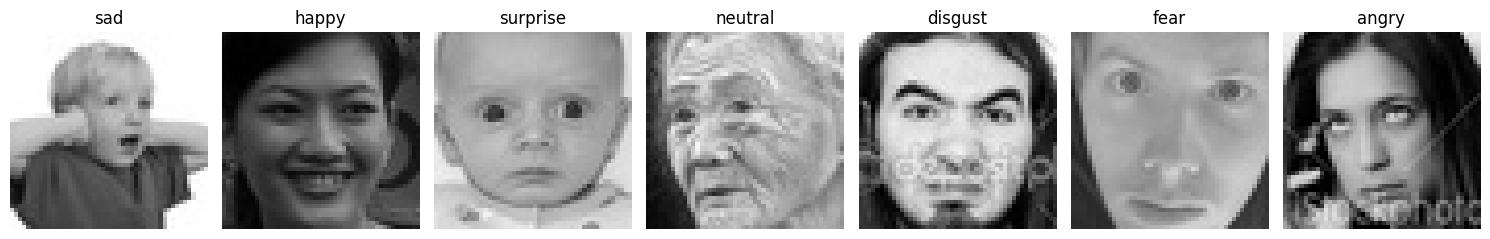

In [6]:
classes = os.listdir(train_path)
print("Classes found:", classes)

plt.figure(figsize=(15, 5))
for i, emotion in enumerate(classes):
    emotion_path = os.path.join(train_path, emotion)
    random_img = random.choice(os.listdir(emotion_path))
    img_path = os.path.join(emotion_path, random_img)
    
    img = cv2.imread(img_path)
    img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
    
    plt.subplot(1, len(classes), i+1)
    plt.imshow(img)
    plt.title(emotion)
    plt.axis("off")

plt.tight_layout()
plt.show()